In [37]:
import numpy as np
import pandas as pd
import openai
import time
import ast
import os
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, \
    average_precision_score

In [ ]:
!echo $OPENAI_API_KEY

In [32]:
df = pd.read_json('../dataset/input/emails_set_batch.jsonl', lines=True)

In [33]:
openai.api_key = os.environ.get('OPENAI_API_KEY')

instruction = "Please provide probability as float numbers whether the given email content is a phishing attempt or not. Use format {'value': binary_value, 'probability_of_true': float_number, 'probability_of_false': float_number}. Response limit - 35 tokens"

attempt = 0
responses = []

In [ ]:
for index, row in df.iterrows():
    message = [{"role": "user", "content": row.prompt}, {"role": "assistant", "content": instruction}]

    # As gpt-3.5-turbo model allows only three requests per minute it is safer to store responses after each batch
    if attempt % 3 == 0 and responses:
        result = pd.DataFrame(responses)
        result.to_json('../dataset/output/turbo_model_responses.jsonl', orient='records', lines=True)
        time.sleep(60)

    try:
        completions = openai.ChatCompletion.create(model="gpt-3.5-turbo", messages=message)

        response = completions.choices[0].message.content
        response = ast.literal_eval(response)
        response["actual"] = row.completion
        responses.append(response)
        print(response)

        attempt += 1

    except Exception as e:
        print(e)
        attempt += 1

In [35]:
result = pd.DataFrame(responses)
result.to_json('../dataset/output/turbo_model_responses.jsonl', orient='records', lines=True)

In [38]:
actual = np.array(result['actual'])
predicted = np.array(result['value'])
probs = np.array(result['probability_of_true'])

In [39]:
# Print accuracy
accuracy = accuracy_score(actual, predicted)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.90


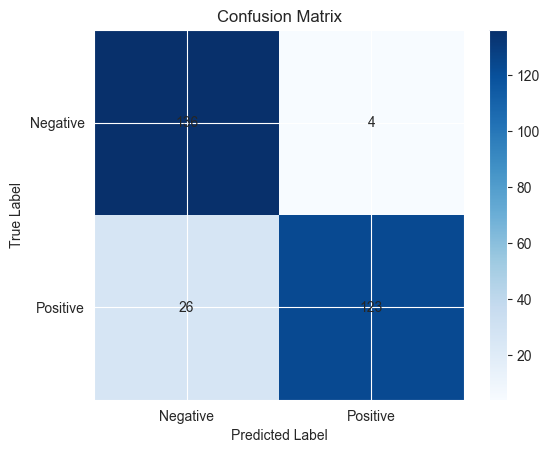

In [40]:
# Plot confusion matrix
conf_matrix = confusion_matrix(actual, predicted)

plt.imshow(conf_matrix, cmap='Blues')
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.yticks([0, 1], ['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
for i in range(2):
    for j in range(2):
        plt.text(j, i, str(conf_matrix[i][j]), ha='center', va='center')
plt.show()

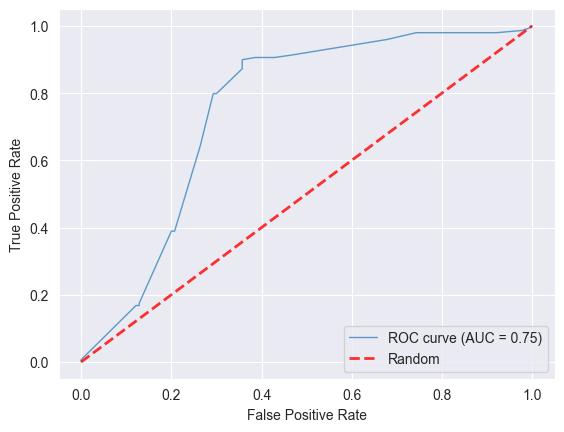

In [41]:
# ROC curve
fpr, tpr, thresholds = roc_curve(actual, probs)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.7,
         label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Random', alpha=.8)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

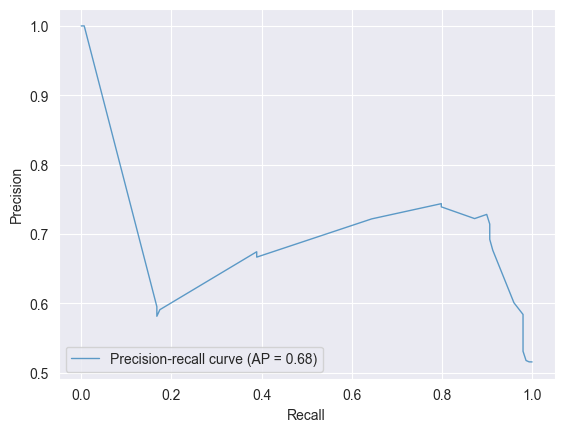

In [42]:
# Precision-Recall curve
precision, recall, _ = precision_recall_curve(actual, probs)
average_precision = average_precision_score(actual, probs)
plt.plot(recall, precision, lw=1, alpha=0.7,
         label='Precision-recall curve (AP = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.show()

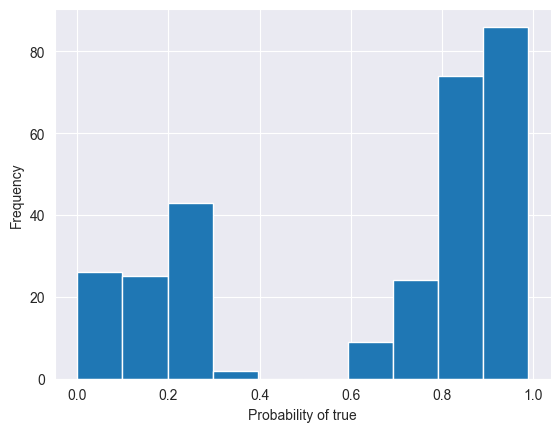

In [43]:
# Histogram of probabilities
plt.hist(probs, bins=10)
plt.xlabel('Probability of true')
plt.ylabel('Frequency')
plt.show()